In [34]:
import os
import uuid
import glob
from datetime import datetime
import pickle
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [35]:
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [36]:
# Function generates the confusion matrics data as a graphic
def print_cmat(cm, labels=None):
  """ Helper function to visualize confusion matrices. """
  ax = plt.subplot()
  sns.heatmap(cm, annot=True, fmt="g", cmap="YlGnBu", linewidths=0.5, ax=ax)
  
  ax.set_title("Confusion Matrix")
  ax.set_xlabel("Predicted Labels")
  ax.set_ylabel("True Labels")
  
  if labels:
      ax.xaxis.set_ticklabels(labels)
      ax.yaxis.set_ticklabels(labels)
  plt.show()

In [37]:
# Model Base Types
Sequential = tf.keras.models.Sequential

# Layers
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout

# Optimizers
Adam = tf.keras.optimizers.Adam

In [38]:
data_df_list = []
for data_path in glob.glob("data/*.csv"):
    data_df_list.append(pd.read_csv(data_path, dtype='float') )
data_df = pd.concat(data_df_list)

data_df = data_df.dropna(subset=['move'], how='all')
# data_df.columns = ['S1', 'C1','S2', 'C2','S3', 'C3','S4', 'C4','S5', 'C5','Label']
# data_df = reorder_data_cols(train_data)
# data_df['move'] = data_df['move'].astype('Int8')
# data_df['player_hand_ranking'] = data_df['player_hand_ranking'].astype('Int8')
data_df.head()

,Unnamed: 0,S1,C1,S2,C2,S3,C3,S4,C4,S5,...,C6,S7,C7,percentage_of_total_chips_hand,percentage_of_hand_bet_pot,percentage_of_total_chips_in_pot,current_stage,move,result,player_hand_ranking
0,0.0,3.0,11.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.166667,0.0875,0.018333,0.0,2.0,1.0,3.0
1,0.0,4.0,5.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.166667,0.0100,0.018333,0.0,0.0,1.0,3.0
2,0.0,4.0,13.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.166667,0.0000,0.018333,0.0,0.0,1.0,3.0
3,0.0,4.0,4.0,2.0,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.166667,0.0000,0.018333,0.0,0.0,1.0,3.0
4,0.0,4.0,1.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.166667,0.0125,0.018333,0.0,0.0,1.0,3.0


In [39]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2536 entries, 0 to 2571
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        2536 non-null   float64
 1   S1                                2536 non-null   float64
 2   C1                                2536 non-null   float64
 3   S2                                2536 non-null   float64
 4   C2                                2536 non-null   float64
 5   S3                                2536 non-null   float64
 6   C3                                2536 non-null   float64
 7   S4                                2536 non-null   float64
 8   C4                                2536 non-null   float64
 9   S5                                2536 non-null   float64
 10  C5                                2536 non-null   float64
 11  S6                                2536 non-null   float64
 12  C6    

<AxesSubplot:xlabel='move', ylabel='Count'>

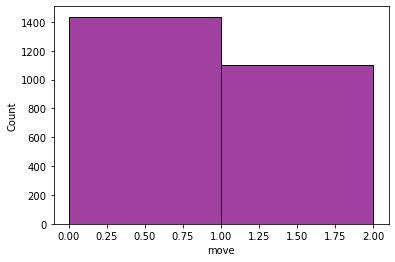

In [40]:
sns.histplot(data=data_df['move'], binwidth=1, color="purple")

<AxesSubplot:xlabel='move', ylabel='Count'>

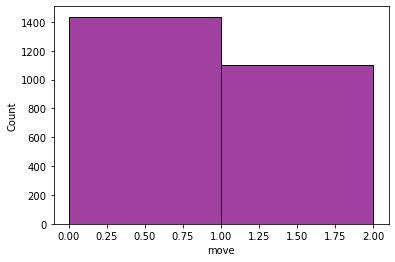

In [41]:
sns.histplot(data=data_df['move'], binwidth=1, color="purple")

/Users/joe/opt/anaconda3/envs/poker/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='player_hand_ranking', ylabel='Density'>

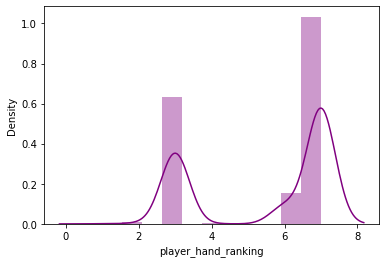

In [42]:
sns.distplot(data_df['player_hand_ranking'], color="purple")

In [43]:
fold_count = len(data_df.loc[data_df['move'] == 0])
call_count = len(data_df.loc[data_df['move'] == 1])
bet_count = len(data_df.loc[data_df['move'] == 2])
print(f'Folds: {fold_count}\nCalls: {call_count}\nBets: {bet_count}')

Folds: 1436
Calls: 548
Bets: 552


In [44]:
x = data_df[['percentage_of_total_chips_hand', 'percentage_of_hand_bet_pot','percentage_of_total_chips_in_pot','current_stage','player_hand_ranking']].to_numpy()
y = data_df['move'].to_numpy()

In [45]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    train_size = .9,
    test_size = .1,
    random_state = 1,
    stratify=y)

In [46]:
# Layer Creation

input_layer = Dense(5, activation="linear")

dense_layer_1 = Dense(500, activation="relu")

dropout_layer_1 = Dropout(.05)

dense_layer_2 = Dense(300, activation="relu")

dropout_layer_2 = Dropout(.05)

dense_layer_3 = Dense(150, activation="relu")

dropout_layer_3 = Dropout(.05)

dense_layer_4 = Dense(50, activation="relu")

dense_layer_5 = Dense(15, activation="relu")

output_layer = Dense(3, activation="linear")

In [47]:
# Sequential Model Architecture Design
model = Sequential()

# Add All Initialized Layers in Effective Sequence
model.add(input_layer)
model.add(dense_layer_1)
model.add(dropout_layer_1)
model.add(dense_layer_2)
model.add(dropout_layer_2)
model.add(dense_layer_3)
model.add(dense_layer_4)
model.add(dropout_layer_3)
model.add(dense_layer_5)
model.add(output_layer)


In [48]:
# Define Adam optimization
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [49]:
batch_size, epochs = 250, 100

# Fit Learning Model Using Training Data and Configured Hyperparameters
history = model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                   verbose=True)

# Get Model Summary for Confirmation
model.summary()

Train on 2282 samples
Epoch 1/100
2282/2282 [==============================] - 1s 545us/sample - loss: 1.4972 - accuracy: 0.3979
Epoch 2/100
2282/2282 [==============================] - 0s 73us/sample - loss: 1.0986 - accuracy: 0.5333
Epoch 3/100
2282/2282 [==============================] - 0s 73us/sample - loss: 1.0986 - accuracy: 0.5368
Epoch 4/100
2282/2282 [==============================] - 0s 72us/sample - loss: 1.0986 - accuracy: 0.5386
Epoch 5/100
2282/2282 [==============================] - 0s 71us/sample - loss: 1.0986 - accuracy: 0.5460
Epoch 6/100
2282/2282 [==============================] - 0s 74us/sample - loss: 1.0986 - accuracy: 0.5359
Epoch 7/100
2282/2282 [==============================] - 0s 72us/sample - loss: 1.0986 - accuracy: 0.5460
Epoch 8/100
2282/2282 [==============================] - 0s 76us/sample - loss: 1.0986 - accuracy: 0.5416
Epoch 9/100
2282/2282 [==============================] - 0s 75us/sample - loss: 1.0986 - accuracy: 0.5469
Epoch 10/100
2282/2282 

2282/2282 [==============================] - 0s 77us/sample - loss: 1.0986 - accuracy: 0.5346
Epoch 78/100
2282/2282 [==============================] - 0s 79us/sample - loss: 1.0986 - accuracy: 0.5399
Epoch 79/100
2282/2282 [==============================] - 0s 77us/sample - loss: 1.0986 - accuracy: 0.5513
Epoch 80/100
2282/2282 [==============================] - 0s 76us/sample - loss: 1.0986 - accuracy: 0.5355
Epoch 81/100
2282/2282 [==============================] - 0s 76us/sample - loss: 1.0986 - accuracy: 0.5329
Epoch 82/100
2282/2282 [==============================] - 0s 77us/sample - loss: 1.0986 - accuracy: 0.5355
Epoch 83/100
2282/2282 [==============================] - 0s 79us/sample - loss: 1.0986 - accuracy: 0.5386
Epoch 84/100
2282/2282 [==============================] - 0s 85us/sample - loss: 1.0986 - accuracy: 0.5469
Epoch 85/100
2282/2282 [==============================] - 0s 78us/sample - loss: 1.0986 - accuracy: 0.5486
Epoch 86/100
2282/2282 [==========================

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              multiple                  30        
_________________________________________________________________
dense_8 (Dense)              multiple                  3000      
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
dense_9 (Dense)              multiple                  150300    
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
dense_10 (Dense)             multiple                  45150     
_________________________________________________________________
dense_11 (Dense)             multiple                 

In [51]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Accuracy: {accuracy}\nLoss: {loss:.4f}")

254/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [52]:
# Get Our Predicted Labels
y_pred = np.argmax(model.predict(x_test), axis=1)

In [53]:
# Create Simple Confusion Matrix as 2D Array
cmat = confusion_matrix(y_true=y_test, 
                        y_pred=y_pred)

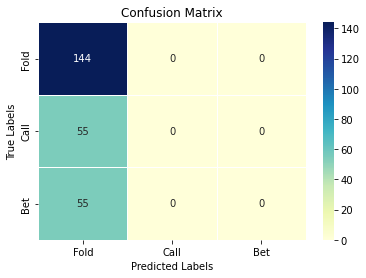

In [54]:
print_cmat(cmat, labels=['Fold','Call','Bet'])

# Equaly Weight Fold, Call, and Bet Sample Counts

In [55]:
fold_data = data_df.loc[data_df['move'] == 0]
call_data = data_df.loc[data_df['move'] == 1]
bet_data = data_df.loc[data_df['move'] == 2]

lowest_count = len(fold_data)
if len(call_data) < lowest_count:
    lowest_count = len(call_data) 
if len(bet_data) < lowest_count:
    lowest_count = len(bet_data) 

data_df_list = [fold_data.head(lowest_count),call_data.head(lowest_count),bet_data.head(lowest_count)]

balanced_data_df = pd.concat(data_df_list)
# balanced_data_df = balanced_data_df.reset_index()
balanced_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1644 entries, 1 to 2547
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        1644 non-null   float64
 1   S1                                1644 non-null   float64
 2   C1                                1644 non-null   float64
 3   S2                                1644 non-null   float64
 4   C2                                1644 non-null   float64
 5   S3                                1644 non-null   float64
 6   C3                                1644 non-null   float64
 7   S4                                1644 non-null   float64
 8   C4                                1644 non-null   float64
 9   S5                                1644 non-null   float64
 10  C5                                1644 non-null   float64
 11  S6                                1644 non-null   float64
 12  C6    

In [56]:
balanced_data_df.head(5)

,Unnamed: 0,S1,C1,S2,C2,S3,C3,S4,C4,S5,...,C6,S7,C7,percentage_of_total_chips_hand,percentage_of_hand_bet_pot,percentage_of_total_chips_in_pot,current_stage,move,result,player_hand_ranking
1,0.0,4.0,5.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.166667,0.0100,0.018333,0.0,0.0,1.0,3.0
2,0.0,4.0,13.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.166667,0.0000,0.018333,0.0,0.0,1.0,3.0
3,0.0,4.0,4.0,2.0,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.166667,0.0000,0.018333,0.0,0.0,1.0,3.0
4,0.0,4.0,1.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.166667,0.0125,0.018333,0.0,0.0,1.0,3.0
5,0.0,1.0,6.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.166667,0.0000,0.018333,0.0,0.0,1.0,3.0


In [57]:
fold_count = len(balanced_data_df.loc[balanced_data_df['move'] == 0])
call_count = len(balanced_data_df.loc[balanced_data_df['move'] == 1])
bet_count = len(balanced_data_df.loc[balanced_data_df['move'] == 2])
print(f'Folds: {fold_count}\nCalls: {call_count}\nBets: {bet_count}')

Folds: 548
Calls: 548
Bets: 548


In [58]:
x = data_df[['percentage_of_total_chips_hand', 'percentage_of_hand_bet_pot','percentage_of_total_chips_in_pot','current_stage','player_hand_ranking']].to_numpy()
y = data_df['move'].to_numpy()

In [59]:
# Sequential Model Architecture Design
bal_model = Sequential()

# Add All Initialized Layers in Effective Sequence
bal_model.add(input_layer)
bal_model.add(dense_layer_1)
bal_model.add(dropout_layer_1)
bal_model.add(dense_layer_2)
bal_model.add(dropout_layer_2)
bal_model.add(dense_layer_3)
bal_model.add(dense_layer_4)
bal_model.add(dropout_layer_3)
bal_model.add(dense_layer_5)
bal_model.add(output_layer)


In [60]:
# Define Adam optimization
optimizer = Adam(lr=0.001)
bal_model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [61]:
batch_size, epochs = 500, 100

# Fit Learning Model Using Training Data and Configured Hyperparameters
history = bal_model.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                   verbose=True)

# Get Model Summary for Confirmation
bal_model.summary()

Train on 2282 samples
Epoch 1/100
2282/2282 [==============================] - 1s 554us/sample - loss: 1.0986 - accuracy: 0.5399
Epoch 2/100
2282/2282 [==============================] - 0s 47us/sample - loss: 1.0986 - accuracy: 0.5381
Epoch 3/100
2282/2282 [==============================] - 0s 48us/sample - loss: 1.0986 - accuracy: 0.5381
Epoch 4/100
2282/2282 [==============================] - 0s 46us/sample - loss: 1.0986 - accuracy: 0.5364
Epoch 5/100
2282/2282 [==============================] - 0s 47us/sample - loss: 1.0986 - accuracy: 0.5390
Epoch 6/100
2282/2282 [==============================] - 0s 47us/sample - loss: 1.0986 - accuracy: 0.5368
Epoch 7/100
2282/2282 [==============================] - 0s 47us/sample - loss: 1.0986 - accuracy: 0.5372
Epoch 8/100
2282/2282 [==============================] - 0s 49us/sample - loss: 1.0986 - accuracy: 0.5294
Epoch 9/100
2282/2282 [==============================] - 0s 48us/sample - loss: 1.0986 - accuracy: 0.5364
Epoch 10/100
2282/2282 

2282/2282 [==============================] - 0s 51us/sample - loss: 1.0986 - accuracy: 0.2213
Epoch 78/100
2282/2282 [==============================] - 0s 52us/sample - loss: 1.0986 - accuracy: 0.2187
Epoch 79/100
2282/2282 [==============================] - 0s 53us/sample - loss: 1.0986 - accuracy: 0.2200
Epoch 80/100
2282/2282 [==============================] - 0s 53us/sample - loss: 1.0986 - accuracy: 0.2187
Epoch 81/100
2282/2282 [==============================] - 0s 54us/sample - loss: 1.0986 - accuracy: 0.2200
Epoch 82/100
2282/2282 [==============================] - 0s 55us/sample - loss: 1.0986 - accuracy: 0.2226
Epoch 83/100
2282/2282 [==============================] - 0s 57us/sample - loss: 1.0986 - accuracy: 0.2200
Epoch 84/100
2282/2282 [==============================] - 0s 66us/sample - loss: 1.0986 - accuracy: 0.2222
Epoch 85/100
2282/2282 [==============================] - 0s 53us/sample - loss: 1.0986 - accuracy: 0.2191
Epoch 86/100
2282/2282 [==========================

In [62]:
loss, accuracy = bal_model.evaluate(x_test, y_test)
print(f"Accuracy: {accuracy}\nLoss: {loss:.4f}")

254/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [63]:
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    train_size = .9,
    test_size = .1,
    random_state = 1,
    stratify=y)

In [64]:
# Get Our Predicted Labels
y_pred = np.argmax(model.predict(x_test), axis=1)

In [65]:
# Create Simple Confusion Matrix as 2D Array
cmat = confusion_matrix(y_true=y_test, 
                        y_pred=y_pred)

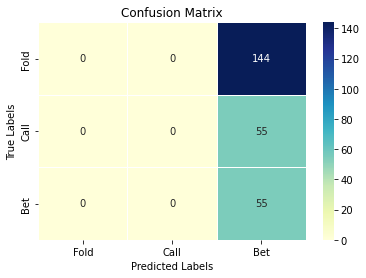

In [66]:
print_cmat(cmat, labels=['Fold','Call','Bet'])